In [1]:
import pandas as pd
import numpy as np

import re
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

In [2]:
dataset_path = 'sentiment_analysis.csv'
df = pd.read_csv(dataset_path, index_col='id')
df.head()

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...


# Preprocessing data
Dữ liệu đầu vào của chúng ta lúc này hiện đang ở dạng văn bản (string), chưa có đặc trưng rõ ràng cũng như không thể đưa vào huấn luyện mô hình được. Vì vậy, chúng ta sẽ tiền xử lý dữ liệu văn bản đầu vào để đưa về một dạng vector đặc trưng nào đó:

* (a) Xây dựng hàm chuẩn hóa văn bản: Văn bản gốc có rất nhiều kí tự thừa thải,
vô nghĩa... Vì vậy, ta cần loại bỏ chúng cũng như áp dụng thêm vài các bước chuẩn hóa văn bản khác để văn bản đầu vào trở nên ít phức tạp hơn, nhằm tăng
cường hiệu quả biểu diễn của vector đặc trưng sau này:

In [3]:
def text_normalize(text):
  # Retweet old acronym "RT" removal
  text = re.sub(r'^RT[\s]+', '', text)

  # Hyperlinks removal
  text = re.sub(r'https?:\/\/.*[\ r\n]*', '', text)

  # Hashtags removal
  text = re.sub(r'#', '', text)

  # Punctuation removal
  text = re.sub(r'[^\ w\s]', '', text)

  # Tokenization
  tokenizer = TweetTokenizer(
    preserve_case = False,
    strip_handles = True,
    reduce_len = True
  )
  text_tokens = tokenizer.tokenize(text)

  return text_tokens

# Build frequency dictionary for words
Có rất nhiều cách để ta có thể tạo vector biểu diễn cho một đoạn văn bản. Trong bài tập này, chúng ta sẽ sử dụng loại vector lưu trữ số lần xuất hiện của các từ thuộc class "positive"và các từ thuộc class "negative"trong một văn bản. Để làm được điều này, đầu tiên chúng ta cần phải xây dựng một bộ từ điển lưu trữ tần suất xuất hiện của toàn bộ mọi từ trong bộ dữ liệu với class tương ứng của nó.

In [4]:
def get_freqs (df) :
 freqs = defaultdict(lambda : 0)
 for idx, row in df.iterrows():
    tweet = row ['tweet']
    label = row ['label']

    tokens = text_normalize(tweet)
    for token in tokens :
        pair = (token, label)
        freqs[pair] += 1

 return freqs

# Build feature vector
Kết hợp hai thành phần trên, ta xây dựng một hàm tạo vector đặc trưng cho văn bản đầu vào.

In [5]:
def get_feature(text, freqs):
 tokens = text_normalize(text)

 X = np.zeros(3)
 X[0] = 1

 for token in tokens:
    X[1] += freqs[(token, 0)]
    X[2] += freqs[(token, 1)]

 return X

# Extract feature for whole data

In [6]:
X = []
y = []

freqs = get_freqs(df)
for idx, row in df.iterrows():
  tweet = row['tweet']
  label = row['label']

  X_i = get_feature(tweet, freqs)
  X.append(X_i)
  y.append(label)

X = np.array(X)
y = np.array(y)

In [7]:
# Split data into train and test set
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)


In [8]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.fit_transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.fit_transform(X_test[:, 1:])

In [9]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

def predict(X, theta):
  dot_product = np.dot(X, theta)
  y_hat = sigmoid(dot_product)

  return y_hat

def compute_loss(y_hat, y):
  y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)

  return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()

def compute_gradient(X, y, y_hat):
  return np.dot(X.T, (y_hat - y)) / y.size

def update_theta(theta, gradient, lr):
  return theta - lr * gradient

def compute_accuracy(X, y, theta):
  y_hat = predict(X, theta).round()
  acc = (y_hat == y).mean()
  return acc

In [10]:
lr = 0.01
epochs = 200
batch_size = 128

np.random.seed(random_state)
theta = np.random.uniform(size=X_train.shape[1])

In [11]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
  train_batch_losses = []
  train_batch_accs = []
  val_batch_losses = []
  val_batch_accs = []

  for i in range(0, X_train.shape[0], batch_size):
    X_i = X_train[i:i+batch_size]
    y_i = y_train[i:i+batch_size]

    # Forward on train data
    y_hat = predict(X_i, theta)
    train_loss = compute_loss(y_hat, y_i)

    # Backward propagation
    gradient = compute_gradient(X_i, y_i, y_hat)
    theta = update_theta(theta, gradient, lr)

    train_batch_losses.append(train_loss)
    train_acc = compute_accuracy(X_train, y_train, theta)
    train_batch_accs.append(train_acc)

    # Apply on validation data
    y_val_hat = predict(X_val, theta)
    val_loss = compute_loss(y_val_hat, y_val)
    val_batch_losses.append(val_loss)

    val_acc = compute_accuracy(X_val, y_val, theta)
    val_batch_accs.append(val_acc)

  train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
  train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
  val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
  val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

  train_losses.append(train_batch_loss)
  train_accs.append(train_batch_acc)
  val_losses.append(val_batch_loss)
  val_accs.append(val_batch_acc)

  print(f'\nEPOCH {epoch + 1}: \tTrainning loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:3f}')


EPOCH 1: 	Trainning loss: 0.824	Validation loss: 0.819394

EPOCH 2: 	Trainning loss: 0.773	Validation loss: 0.769830

EPOCH 3: 	Trainning loss: 0.733	Validation loss: 0.729802

EPOCH 4: 	Trainning loss: 0.700	Validation loss: 0.697890

EPOCH 5: 	Trainning loss: 0.674	Validation loss: 0.672646

EPOCH 6: 	Trainning loss: 0.654	Validation loss: 0.652734

EPOCH 7: 	Trainning loss: 0.638	Validation loss: 0.637018

EPOCH 8: 	Trainning loss: 0.625	Validation loss: 0.624576

EPOCH 9: 	Trainning loss: 0.614	Validation loss: 0.614687

EPOCH 10: 	Trainning loss: 0.606	Validation loss: 0.606788

EPOCH 11: 	Trainning loss: 0.600	Validation loss: 0.600452

EPOCH 12: 	Trainning loss: 0.594	Validation loss: 0.595345

EPOCH 13: 	Trainning loss: 0.590	Validation loss: 0.591214

EPOCH 14: 	Trainning loss: 0.587	Validation loss: 0.587859

EPOCH 15: 	Trainning loss: 0.584	Validation loss: 0.585127

EPOCH 16: 	Trainning loss: 0.581	Validation loss: 0.582895

EPOCH 17: 	Trainning loss: 0.579	Validation loss

[Text(0.5, 0, 'Epochs'),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, 'Training Accuracy')]

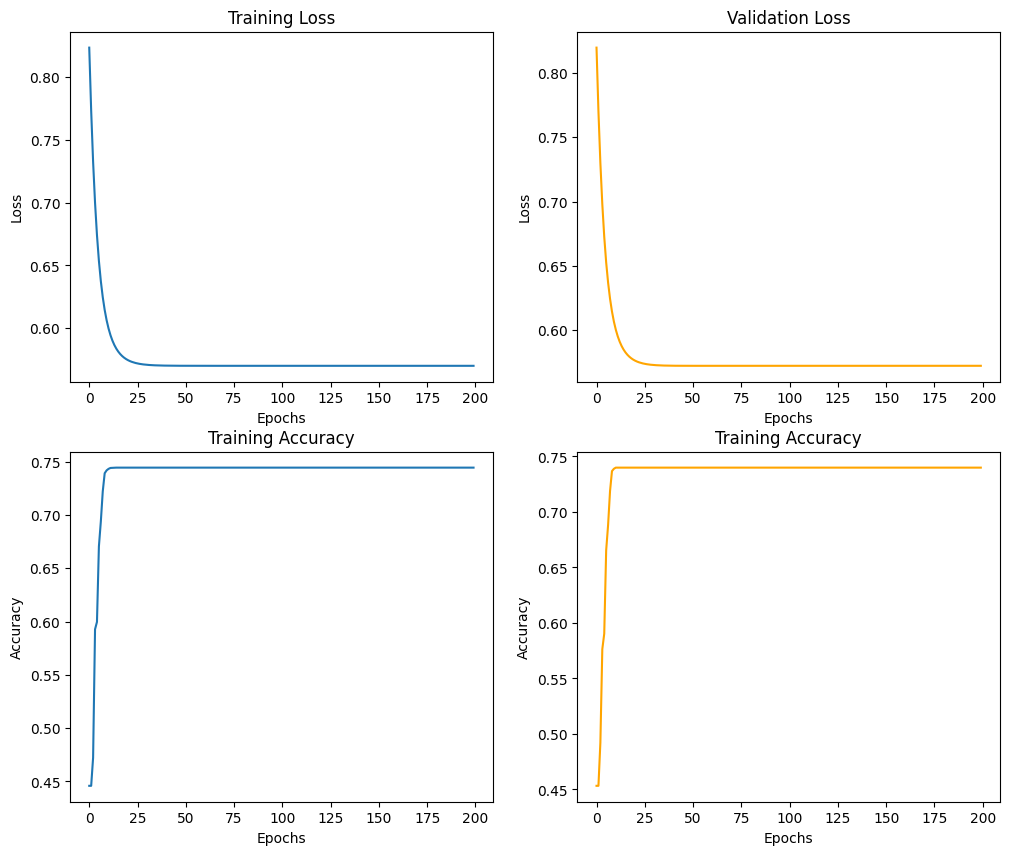

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epochs', ylabel='Loss', title='Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epochs', ylabel='Loss', title='Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epochs', ylabel='Accuracy', title='Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epochs', ylabel='Accuracy', title='Training Accuracy')

In [13]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)

print('Evaluation on validation and test set:')
print(f'Validation set accuracy: {val_set_acc:.3f}')
print(f'Test set accuracy: {test_set_acc:.3f}')

Evaluation on validation and test set:
Validation set accuracy: 0.740
Test set accuracy: 0.751


In [ ]:
X = [[22.3, -1.5, 1.1, 1]]
theta = [0.1, -0.15, 0.3, -0.2]
print(predict(X, theta))

[0.92988994]


In [ ]:
y = np.array([1, 0, 0, 1])
y_hat = np.array([0.8, 0.75, 0.3,0.95])
print(compute_loss(y_hat, y))

0.5043515376900958


In [ ]:
X = np.array([[1, 2], [2, 1], [1, 1], [2, 2]])
y_true = np.array([0, 1, 0, 1])
y_pred = np.array([0.25, 0.75,0.4, 0.8])

gradient = compute_gradient(X, y_true, y_pred)
print(gradient)

[-0.0625  0.0625]


In [ ]:
def compute_accuracy(y_true, y_pred):
  y_pred_rounded = np.round(y_pred)
  accuracy = np.mean(y_true == y_pred_rounded)

  return accuracy

y_true = np.array([1, 0, 1, 1])
y_pred = np.array([0.85, 0.35, 0.9, 0.75])
print(compute_accuracy(y_true, y_pred))

1.0


In [ ]:
def compute_gradient(X, y_true, y_pred):
  gradient = np.dot(X.T, (y_pred - y_true)) / y_true.size

  return gradient
X = np.array([[1, 3], [2, 1], [3, 2], [1, 2]])
y_true = np.array([1, 0, 1, 1])
y_pred = np.array([0.7, 0.4, 0.6, 0.85])
print(compute_gradient(X, y_true , y_pred))

[-0.2125 -0.4   ]
